In [123]:
import pandas as pd
pd.set_option('display.max_columns', None)  

In [124]:
from scipy.stats import levene, shapiro, f_oneway, kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
from sklearn import preprocessing
from scipy.stats import kstest, ttest_ind, ks_2samp, zscore

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# A. Import data

In [126]:
# Dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 
  
# data (as pandas dataframes) 
X = aids_clinical_trials_group_study_175.data.features 
y = aids_clinical_trials_group_study_175.data.targets 

In [127]:
X.loc[:,"cd4_diff"] = X["cd420"] - X["cd40"]

/opt/anaconda3/envs/bio275_project/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [128]:
X_history = X.loc[X["str2"]==1].reset_index(drop=True)
X_no_history = X.loc[X["str2"]==0].reset_index(drop=True)
y_history = y.loc[X["str2"]==1].reset_index(drop=True)
y_no_history = y.loc[X["str2"]==0].reset_index(drop=True)

In [129]:
dict_str2 = {0:"Without antiretroviral history",1:"With antiretroviral history"}
dict_trt = {0:"ZDV only",1:"ZDV + ddI",2:"ZDV + Zal", 3:"ddI only"}

## Summary Statistics

In [130]:
X_cd4_summary = X.groupby(["str2","trt"]).agg({"cd4_diff":["mean","median","std","var"]})
X_cd4_summary.index = pd.MultiIndex.from_product([list(map(dict_str2.get, X_cd4_summary.index.get_level_values("str2").unique().tolist())),
                                                  list(map(dict_trt.get, X_cd4_summary.index.get_level_values("trt").unique().tolist()))],
                                              names=X_cd4_summary.index.names)
X_cd4_summary.index = X_cd4_summary.index.set_names(["Group", "Treatment"])
X_cd4_summary

cd4_diff                     \
                                               mean median         std   
Group                          Treatment                                 
Without antiretroviral history ZDV only    5.336323    7.0  109.960185   
                               ZDV + ddI  75.361502   70.0  155.620141   
                               ZDV + Zal  36.759434   35.5  108.892328   
                               ddI only   45.457983   39.0  115.563800   
With antiretroviral history    ZDV only  -33.233010  -27.0   97.757406   
                               ZDV + ddI  40.032362   30.0  134.279410   
                               ZDV + Zal   7.375000   -0.5  113.289873   
                               ddI only   13.151703    0.0  111.982496   

                                                        
                                                   var  
Group                          Treatment                
Without antiretroviral history ZDV only   12091.242233  
                               ZDV + ddI  24217.628134  
                               ZDV + Zal  11857.539010  
                               ddI only   13354.991898  
With antiretroviral history    ZDV only    9556.510465  
                               ZDV + ddI  18030.959988  
                               ZDV + Zal  12834.595257  
                               ddI only   12540.079399

In [131]:
sns.set(style="whitegrid")

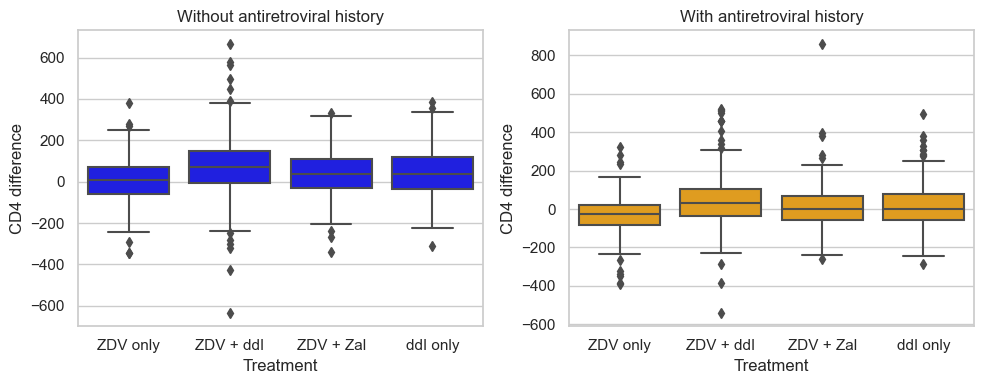

In [132]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

ax = sns.boxplot(x='trt', y='cd4_diff', data=X_no_history, color='blue', ax=axes[0])
ax.set_title("Without antiretroviral history")
ax.set_xlabel("Treatment")
ax.set_ylabel("CD4 difference")
_=ax.set_xticklabels(["ZDV only","ZDV + ddI","ZDV + Zal", "ddI only"])

ax = sns.boxplot(x='trt', y='cd4_diff', data=X_history, color='orange', ax=axes[1])
# ax = sns.swarmplot(x="trt", y="cd4_diff", data=X_history, color='#7d0013', size=2)
ax.set_title("With antiretroviral history")
ax.set_xlabel("Treatment")
ax.set_ylabel("CD4 difference")
_=ax.set_xticklabels(["ZDV only","ZDV + ddI","ZDV + Zal", "ddI only"])


plt.tight_layout()
plt.show()


# B. Comparison across all groups

## B1. Analysis of variance (ANOVA)
null hypothesis: The means are the same for all the data groups.<br>
alternative hypothesis: The means in at least one pair between the treatment groups are different.

#### With antiretroviral history

In [133]:
# ANOVA model
res = stat()
res.anova_stat(df=X_history, res_var='cd4_diff', anova_model='cd4_diff ~ C(trt)')

res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(trt),3.0,8.495937e+05,283197.908001,21.402971,1.605039e-13
Residual,1249.0,1.652641e+07,13231.709841,NaN,NaN


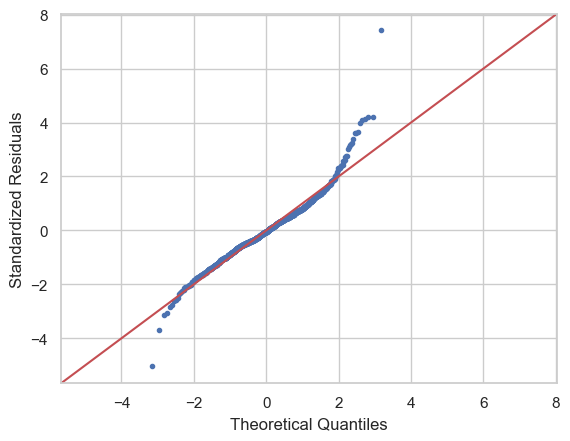

In [134]:
# Residual Distribution
sm.qqplot(res.anova_std_residuals, line='45', markersize=3)
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

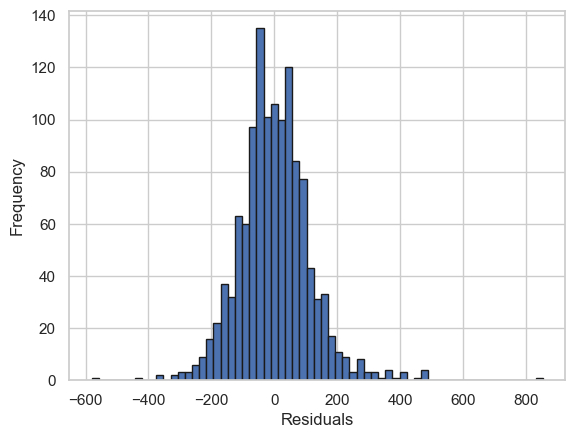

In [135]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [136]:
# Shapiro-Wilk test: check the normal distribution of residuals.
statistic, p_value = shapiro(res.anova_model_out.resid)
print(f'Statistic: {statistic}')
print(f'p-value:{p_value}')

Statistic: 0.959419846534729
p-value:3.4663650837863947e-18


In [137]:
# KS test for check normality
# standardize
residual_zscored = preprocessing.scale(res.anova_model_out.resid)

statistic, p_value = kstest(residual_zscored, 'norm')
print(f'Statistic: {statistic}')
print(f'p-value:{p_value}')

Statistic: 0.05487029782682984
p-value:0.0010157592925892584


In [138]:
# Check assumptions of ANOVA¶
# Levene's test: assesses the homogeneity of variance
statistic, p_value=levene(X_history.loc[X_history["trt"]==0,"cd4_diff"], 
                          X_history.loc[X_history["trt"]==1,"cd4_diff"], 
                          X_history.loc[X_history["trt"]==2,"cd4_diff"], 
                          X_history.loc[X_history["trt"]==3,"cd4_diff"])

print(f'Statistic: {statistic}')
print(f'p-value:{p_value}')

Statistic: 5.548584099953611
p-value:0.0008776144384195461


#### Without antiretroviral history

In [139]:
# ANOVA model
res = stat()
res.anova_stat(df=X_no_history, res_var='cd4_diff', anova_model='cd4_diff ~ C(trt)')

res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(trt),3.0,5.434158e+05,181138.599907,11.847142,1.301770e-07
Residual,882.0,1.348547e+07,15289.644842,NaN,NaN


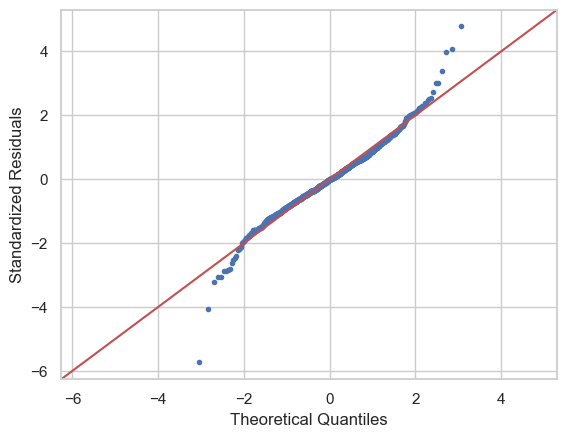

In [140]:
# Residual Distribution
sm.qqplot(res.anova_std_residuals, line='45', markersize=3)
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

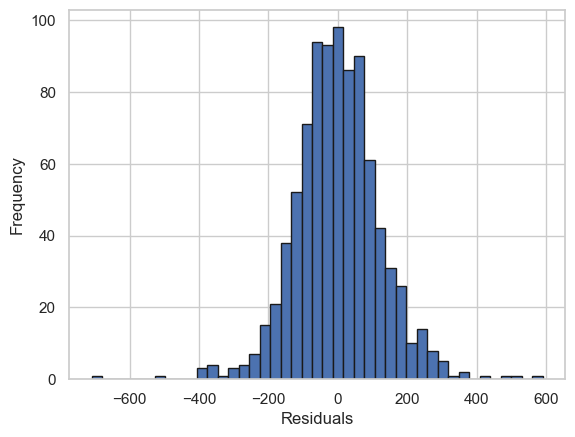

In [141]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [142]:
# Shapiro-Wilk test: check the normal distribution of residuals.
statistic, p_value = shapiro(res.anova_model_out.resid)
print(f'Statistic: {statistic}')
print(f'p-value:{p_value}')

Statistic: 0.976485013961792
p-value:9.242548393295635e-11


In [143]:
# KS test for check normality
# standardize
residual_zscored = preprocessing.scale(res.anova_model_out.resid)

statistic, p_value = kstest(residual_zscored, 'norm')
print(f'Statistic: {statistic}')
print(f'p-value:{p_value}')

Statistic: 0.044298499736912356
p-value:0.05994262487388213


In [144]:
# Check assumptions of ANOVA¶
# Levene's test: assesses the homogeneity of variance
statistic, p_value=levene(X_no_history.loc[X_no_history["trt"]==0,"cd4_diff"], 
                          X_no_history.loc[X_no_history["trt"]==1,"cd4_diff"], 
                          X_no_history.loc[X_no_history["trt"]==2,"cd4_diff"], 
                          X_no_history.loc[X_no_history["trt"]==3,"cd4_diff"])

print('Statistic:%.2f'%statistic)
print('p-value:%.2f'%p_value)

Statistic:5.55
p-value:0.00


It seems assumptions of ANOVA is not followed very well (normality of residuals, variance), so supplement with below test to see if similar conclusion is drawn.

## B2. Supplement with Kruskal-Wallis test ##
non-parametric test and an alternative to Anova when assumptions are not met<br>
null hypothesis: The median is the same for all the data groups.<br>
alternative hypothesis: The median is not equal for at least one pair of the data groups.

#### With antiretroviral history

In [145]:
# Kruskal-Wallis test: Alternative to ANOVA
statistic, p_value = kruskal(X_history.loc[X_history["trt"]==0,"cd4_diff"], 
                          X_history.loc[X_history["trt"]==1,"cd4_diff"], 
                          X_history.loc[X_history["trt"]==2,"cd4_diff"], 
                          X_history.loc[X_history["trt"]==3,"cd4_diff"])
print(f'Statistic: {statistic}')
print(f'p-value:{p_value}')

Statistic: 62.32601085222472
p-value:1.8713761751918154e-13


#### Without antiretroviral history

In [146]:
# Kruskal-Wallis test: Alternative to ANOVA
statistic, p_value = kruskal(X_no_history.loc[X_no_history["trt"]==0,"cd4_diff"], 
                          X_no_history.loc[X_no_history["trt"]==1,"cd4_diff"], 
                          X_no_history.loc[X_no_history["trt"]==2,"cd4_diff"], 
                          X_no_history.loc[X_no_history["trt"]==3,"cd4_diff"])
print(f'Statistic: {statistic}')
print(f'p-value:{p_value}')

Statistic: 35.588303420612014
p-value:9.149933643005939e-08


Draw same conclusion that the central measure across treatment groups are significantly different

# C. Comparison between two groups

The data approximately follows normal as shown below.

#### With antiretroviral history

In [147]:
# KS test for check normality
for x in [0,1,2,3]:
    temp = X_history.loc[X_history["trt"]==x,"cd4_diff"]
    # standardize
    residual_zscored = preprocessing.scale(temp)

    statistic, p_value = kstest(residual_zscored, 'norm')
    print(dict_trt.get(x))
    print(f'Statistic: {statistic}')
    print(f'p-value:{p_value}')

ZDV only
Statistic: 0.07289775594221648
p-value:0.07127709652383829
ZDV + ddI
Statistic: 0.07308806817988378
p-value:0.07005296536462036
ZDV + Zal
Statistic: 0.05332685269356541
p-value:0.3259136665500798
ddI only
Statistic: 0.06724501845823777
p-value:0.10290672035450787


#### Without antiretroviral history

In [148]:
# KS test for check normality
for x in [0,1,2,3]:
    temp = X_no_history.loc[X_no_history["trt"]==x,"cd4_diff"]
    # standardize
    residual_zscored = preprocessing.scale(temp)

    statistic, p_value = kstest(residual_zscored, 'norm')
    print(dict_trt.get(x))
    print(f'Statistic: {statistic}')
    print(f'p-value:{p_value}')

ZDV only
Statistic: 0.04807022311135434
p-value:0.6631495515436308
ZDV + ddI
Statistic: 0.08660136033971609
p-value:0.07717682912989954
ZDV + Zal
Statistic: 0.03869857837340196
p-value:0.8962755134168194
ddI only
Statistic: 0.034711512330421246
p-value:0.9269607461725996


### C1. Welch Two Sample t-test

Above Levene's test suggests variances are not significantly the same across all groups. For simplicity, perform Welch Two Sample t-test (unequal variance) for all below pairwise testings, and follow the paper to use two-sided testing without adjustment for multiple comparisons.

#### With antiretroviral history¶

In [149]:
# T-test (unequal variance)
for x in [0,1,2,3]:
    temp = X_history.loc[X_history["trt"]==x,"cd4_diff"]
    statistic, p_value = ttest_ind(X_history.loc[X_history["trt"]==0,"cd4_diff"], 
              temp, 
              equal_var=False, 
              alternative='two-sided')
    
    print(dict_trt.get(x))
    print(f'Statistic: {statistic}')
    print(f'p-value:{p_value}')

ZDV only
Statistic: 0.0
p-value:1.0
ZDV + ddI
Statistic: -7.753933271346542
p-value:4.1972373593337166e-14
ZDV + Zal
Statistic: -4.783582854924399
p-value:2.1637211993595033e-06
ddI only
Statistic: -5.553920641395739
p-value:4.1355635178711553e-08


#### Without antiretroviral history¶

In [150]:
# T-test (unequal variance)
for x in [0,1,2,3]:
    temp = X_no_history.loc[X_no_history["trt"]==x,"cd4_diff"]
    statistic, p_value = ttest_ind(X_no_history.loc[X_no_history["trt"]==0,"cd4_diff"], 
              temp, 
              equal_var=False, 
              alternative='two-sided')
    
    print(dict_trt.get(x))
    print(f'Statistic: {statistic}')
    print(f'p-value:{p_value}')

ZDV only
Statistic: 0.0
p-value:1.0
ZDV + ddI
Statistic: -5.4038691679608535
p-value:1.1537834859154843e-07
ZDV + Zal
Statistic: -2.9939999912786983
p-value:0.0029114936036771727
ddI only
Statistic: -3.819651721452476
p-value:0.000152020866514568
